# Preparing a Multi-task Dataset

The dataset we created in Tutorial 2 can be used to train "single-task" models, which are models that predict values for one response variable (in this case, the $pK_i$ for compounds that inhibit the cdk3 
transporter). AMPL also enables you to train "multi-task" models that can predict multiple response variables from one set of inputs. This can be beneficial when you have a set of target proteins that are similar structurally or in
some way; features of molecules that predict their actions on one target may predict their actions against 
other targets as well.

In this tutorial, we will encapsulate the steps we performed in Tutorial 2 into a 'curate' function, which we will apply to 3 datasets: our original cdk3 dataset,
plus similar datasets for the related transporters cdk2 and cdk4. We will then combine the curated datasets for the individual targets to produce one "multi-task" dataset.

## Encapsulating the Curation Process
To make it easier to apply the same curation steps to multiple datasets, we define a `curate` function as follows. This function simply calls the AMPL functions
that we used in Tutorial 2:

In [ ]:
import os
import pandas as pd

from atomsci.ddm.utils.struct_utils import base_smiles_from_smiles
from atomsci.ddm.utils.data_curation_functions import compute_negative_log_responses, standardize_relations
from atomsci.ddm.utils.curate_data import remove_outlier_replicates, aggregate_assay_data


def curate(df):
     # Standardize SMILES strings
     df['base_rdkit_smiles'] = base_smiles_from_smiles(df.smiles.tolist(), workers=8)

     df = df[(df["standard_units"] == "uM") | (df["standard_units"] == "nM")]

     # Convert Kis to pIC50s
     df = compute_negative_log_responses(df, 
                              unit_col='standard_units',
                              value_col='standard_value',
                              new_value_col='pIC50',
                              relation_col='standard_relation',
                              unit_conv={'uM':lambda x: x*1e-6, 'nM':lambda x: x*1e-9},
                              inplace=False)
     
     # Standardize relations for censored data
     df = standardize_relations(df, db='ChEMBL', 
                    rel_col='standard_relation',
                    output_rel_col='fixed_relation')

     # Remove outliers
     df = remove_outlier_replicates(df, id_col='molecule_chembl_id',
                                   response_col='pIC50', max_diff_from_median=1.0)

     # Average/aggregate replicate values
     df = aggregate_assay_data(df, 
                              value_col='pIC50',
                              output_value_col='avg_pIC50',
                              id_col='molecule_chembl_id',
                              smiles_col='base_rdkit_smiles',
                              relation_col='fixed_relation',
                              label_actives=False
                         )
     return df

We use this function to curate datasets for three related targets (all neurotransmitter reuptake transporters):

In [ ]:
cdk_files = ["Single_protein\CDK1_all\DOWNLOAD-6LKFVkIM-l_JcPPZSjHgUEGhQBPQlvBIoV5IiF9OOBk=.csv", 
             "Single_protein\CDK2_all\DOWNLOAD-mhDy8yRQT2h0O8tKdgTFxXrPaXQzqsGNqKNe5jXpI6Q=.csv",
             "Single_protein\Chembl_cdk3\DOWNLOAD-75dcVsjkD8VO9Jn3cMGtuRPuy-VAEO2QSIOLq0EXj7w=.csv",
             "Single_protein\Chembl_cdk4\DOWNLOAD-iXeW41Vld2Mica1pe83dlB_ReIK2FdO2k6v5F95AAaw=.csv",
             "Single_protein\Chembl_cdk5\DOWNLOAD-FICmFBAQNiDtsCEPclRGSy3AAou-FRKnD2zT2EgCW-c=.csv",
             "Single_protein\Chembl_cdk6\DOWNLOAD-EtxPsLUrJ1YbPElFasIZZDsNwE0p0is4KzK3E64p8ms=.csv",
             "Single_protein\Chembl_cdk7\DOWNLOAD-E9jG39dlhX2UMIZjctP75OgcumH6ulDUcp7M1ukVqsE=.csv",
             "Single_protein\Chembl_cdk8\DOWNLOAD-VVoZg8MxAalxqibuI6S9LPX5Ai7344DpPK5Rbx5UeE0=.csv",
             "Single_protein\Chembl_cdk9_mono\DOWNLOAD-BAZxlp4WKz4mctvZv0789tKcgKhUkJze642no8lmj-k=.csv",
             "Single_protein\Chembl_cdk10\DOWNLOAD-k60UWWW4ayartxrupvBHcuAT5uUxzNL7HEQIbsMnn10=.csv",
             "Single_protein\Chembl_cdk12\DOWNLOAD-Tey1s2ZZ7dl4cFU2fR57WJ0yAzCkeoehLSxDiCdYy98=.csv",
             "Single_protein\Chembl_cdk13\DOWNLOAD-oaj4PRGHjIXgoqJp3A2tqcnqW8m19pw_CMhg2zmnsoA=.csv",
             "Single_protein\PFTAIRE1_CDK14\DOWNLOAD-IjlhpqiEOYngxVNNHSxivCR6bb49WEuq9Kj6xOto7P4=.csv",
             "Single_protein\PFTAIRE2_CDK15\DOWNLOAD-osPYaAXosexI4UjUyX9PJt6cJXEz3-9Yuxuq9gZc4yg=.csv"]

In [ ]:
index = 1
for f in cdk_files:
     print(f'{f}\n')
     df = pd.read_csv(f)
     df = df.rename(columns={'Standard Units': 'standard_units'})
     df = df.rename(columns={'Standard Type': 'standard_type'})
     df = df.rename(columns={'Standard Value': 'standard_value'})
     df = df.rename(columns={'Standard Relation': 'standard_relation'})
     df = df.rename(columns={'Smiles': 'smiles'})
     df = df.rename(columns={'Molecule ChEMBL ID': 'molecule_chembl_id'})
     print("Original data shape: ", df.shape)
     df = curate(df)
     print("Curated data shape: ", df.shape)
     print(df.columns, '\n')
     df.to_csv('Single_protein\curated_cdk_' + str(index) + ".csv", index=False)
     index += 1
     if (index == 11):
          index += 1

## Combine Single-Task Datasets into One Multi-Task Dataset
We use the `pandas` [merge](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) function to combine the three curated datasets into one:

In [95]:
cdk1_df = pd.read_csv('Single_protein/curated_cdk_1.csv')
cdk2_df = pd.read_csv('Single_protein/curated_cdk_2.csv')
cdk3_df = pd.read_csv('Single_protein/curated_cdk_3.csv')
cdk4_df = pd.read_csv('Single_protein/curated_cdk_4.csv')
cdk5_df = pd.read_csv('Single_protein/curated_cdk_5.csv')
cdk6_df = pd.read_csv('Single_protein/curated_cdk_6.csv')
cdk7_df = pd.read_csv('Single_protein/curated_cdk_7.csv')
cdk8_df = pd.read_csv('Single_protein/curated_cdk_8.csv')
cdk9_df = pd.read_csv('Single_protein/curated_cdk_9.csv')
cdk10_df = pd.read_csv('Single_protein/curated_cdk_10.csv')
cdk12_df = pd.read_csv('Single_protein/curated_cdk_12.csv')
cdk13_df = pd.read_csv('Single_protein/curated_cdk_13.csv')
cdk14_df = pd.read_csv('Single_protein/curated_cdk_14.csv')
cdk15_df = pd.read_csv('Single_protein/curated_cdk_15.csv')

# List of dataframes and their suffixes
dfs = [
    (cdk1_df, '_cdk1'),
    (cdk2_df, '_cdk2'),
    (cdk4_df, '_cdk4'),
    (cdk5_df, '_cdk5'),
    (cdk6_df, '_cdk6'),
    (cdk7_df, '_cdk7'),
    (cdk8_df, '_cdk8'),
    (cdk9_df, '_cdk9'),
    (cdk12_df, '_cdk12'),
    (cdk13_df, '_cdk13'),
]

# Initial merge
df = dfs[0][0]  # Start with the first dataframe

# Loop through the rest of the dataframes and merge
for next_df, suffix in dfs[1:]:
    df = df.merge(next_df, how='outer', on=['compound_id', 'base_rdkit_smiles'], suffixes=[None, suffix])

df = df.rename(columns={"relation" : "relation_cdk1", "avg_pIC50" : "avg_pIC50_cdk1"})

print(df.columns.values)
df.to_csv('Single_protein/cdk_all.csv', index=False)

['compound_id' 'base_rdkit_smiles' 'relation_cdk1' 'avg_pIC50_cdk1'
 'relation_cdk2' 'avg_pIC50_cdk2' 'relation_cdk4' 'avg_pIC50_cdk4'
 'relation_cdk5' 'avg_pIC50_cdk5' 'relation_cdk6' 'avg_pIC50_cdk6'
 'relation_cdk7' 'avg_pIC50_cdk7' 'relation_cdk8' 'avg_pIC50_cdk8'
 'relation_cdk9' 'avg_pIC50_cdk9' 'relation_cdk12' 'avg_pIC50_cdk12'
 'relation_cdk13' 'avg_pIC50_cdk13']


In [93]:
for df_tuple in dfs:
    cdk_df = df_tuple[0]
    suffix = df_tuple[1]
    odir = "test_models/"
    compound_id = "compound_id"
    smiles_col = "base_rdkit_smiles"
    response_col = "avg_pIC50"
    params = {
        "prediction_type": "regression",
        "dataset_key": "Single_protein\curated" + suffix[:4] + "_" + suffix[4:] + ".csv",
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "previously_split": "False",
        "split_only": "False",
        "splitter": "random",
        "split_strategy" : "train_valid_test",
        "featurizer": "computed_descriptors",
        "descriptor_type" : "rdkit_raw",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        "rerun": "False",
        "result_dir": odir
    }

    ampl_param = parse.wrapper(params)
    pl = mp.ModelPipeline(ampl_param)
    pl.train_model()

C:\Desktop\Hackathon\AMPL\atomsci\ddm\pipeline\transformations.py:250: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)
C:\Desktop\Hackathon\AMPL\atomsci\ddm\pipeline\transformations.py:250: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)
C:\Desktop\Hackathon\AMPL\atomsci\ddm\pipeline\transformations.py:250: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)
C:\Desktop\Hackathon\AMPL\atomsci\ddm\pipeline\transformations.py:250: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)
C:\Desktop\Hackathon\AMPL\atomsci\ddm\pipeline\transformations.py:250: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)
C:\Desktop\Hackathon\AMPL\atomsci\ddm\pipeline\transformatio

In [94]:
# Model Performance
from atomsci.ddm.pipeline import compare_models as cm

test_perf_df = cm.get_filesystem_perf_results("test_models/", pred_type='regression')

# show most useful columns
test_perf_df[['model_uuid', "split_uuid", 'model_type', 'splitter', 'best_valid_r2_score', 'best_train_r2_score']].sort_values(by="best_valid_r2_score", ascending=False)

Found data for 14 models under test_models/


,model_uuid,split_uuid,model_type,splitter,best_valid_r2_score,best_train_r2_score
10,69ff2ce3-914d-46eb-816c-576c07bc191a,dcfad93b-ee54-4eec-a61e-20e211b08a77,RF,random,0.777387,0.966934
3,0f5387f0-7643-4a91-acdd-7d67e333f5e3,beec2998-4f34-45ad-aa09-4720d5bfded8,RF,random,0.703314,0.958673
8,6a84e6e3-1a26-49dc-b899-140bf800ac1b,dc2c53e6-bc48-4a3d-b42e-a8e8e396a672,RF,random,0.698383,0.948730
2,a387cf2e-caf9-45a4-b305-931e2088b221,4c90cdc7-3eb6-47b3-8e7f-a79d9580f4dd,RF,random,0.676819,0.950881
6,26b7cdb1-66ac-44f0-94e1-9b7db745ef50,1dec0f48-72f8-4bb2-a940-f0a0839fde52,RF,random,0.601233,0.948502
12,3eaffbdc-0cad-43ed-89ac-ce6438582cbc,fac59b87-1895-4fd1-b0d7-f5f47f71bc14,RF,random,0.576634,0.931471
0,8bf29ccb-c127-4748-8eb8-733dd15d9f43,122bb6e2-934e-49a9-a823-7866f633b41b,RF,random,0.574304,0.938059
13,6c3bb782-f21f-463e-9b60-59e5bad5e2d9,60d7c73e-47a2-4f96-af38-a1d8ab6718a9,RF,random,0.539251,0.940016
9,56ffebec-a463-4ed1-9838-d5b68c7b29fb,4f86959e-8daa-418f-aebc-1e28d36197b5,RF,random,0.443130,0.921579
11,d975d9ef-a5ea-4dfe-b592-0344eaa131b1,eceb9242-f2fa-4ffe-aa21-13b58c8c771d,RF,random,0.396842,0.907695


In [ ]:
# 14, 15, 10, 3

In [ ]:
df.head()

In the table above, we see NaN's in the avg_pIC50 columns on rows where there are data for some targets but not others. For a multitask dataset, we generally want to have some compounds with data for more than one target. We can plot a Venn diagram to see how many compounds have $pK_i$'s for each pair of targets and for all three.

In [ ]:
import matplotlib_venn as mpv
_ = mpv.venn3([set(df.loc[df.avg_pIC50_cdk1.notna(), 'base_rdkit_smiles']),
           set(df.loc[df.avg_pIC50_cdk2.notna(), 'base_rdkit_smiles']),
           set(df.loc[df.avg_pIC50_cdk3.notna(), 'base_rdkit_smiles']),
           ],
          set_labels=['cdk1', 'cdk2', 'cdk3'])

In this dataset, there is quite a bit of overlap between the target-specific compound sets. This is an ideal situation for multitask modeling, since it allows the model to 
learn combinations of features that are predictive for two or more targets simultaneously.  


In a later tutorial we'll use this dataset to demonstrate how to perform a multitask scaffold split and how to train a multitask regression model.

In [97]:
import atomsci.ddm.pipeline.model_pipeline as mp
import atomsci.ddm.pipeline.parameter_parser as parse

## Do a standard multitask scaffold split

In [96]:
response_cols = ""
for col in df.filter(like="avg_pIC50", axis=1).columns.values:
    response_cols += col + ","
response_cols = response_cols[:-1]
response_cols

'avg_pIC50_cdk1,avg_pIC50_cdk2,avg_pIC50_cdk4,avg_pIC50_cdk5,avg_pIC50_cdk6,avg_pIC50_cdk7,avg_pIC50_cdk8,avg_pIC50_cdk9,avg_pIC50_cdk12,avg_pIC50_cdk13'

In [ ]:
import atomsci.ddm.utils.split_response_dist_plots as srdp


splitter = 'multitaskscaffold'
dset_file = 'Single_protein/cdk_all.csv'
params = {
    "dataset_key" : dset_file,
    "splitter": splitter,
    "split_valid_frac": "0.20",
    "split_test_frac": "0.20",
    "split_strategy": "train_valid_test",
    "previously_split": "True",
    "previously_featurized": "True",
    "prediction_type": "regression",
    "response_cols" : response_cols,
    "id_col": "compound_id",
    "smiles_col" : "base_rdkit_smiles",
    "result_dir": 'models/',
    "featurizer": "computed_descriptors",
    "descriptor_type" : "rdkit_raw",
    "model_type": "RF",
    "transformers": "True",
    "rerun": "True",
    "split_uuid" : "6edb6cc5-7446-4133-a897-bc0fc8642418"
}
pparams = parse.wrapper(params)
pl = mp.ModelPipeline(pparams)
pl.train_model()

In [113]:
# Model Performance
from atomsci.ddm.pipeline import compare_models as cm
final_model_perf = cm.get_filesystem_perf_results("final_models/", pred_type='regression')
# show most useful columns
final_model_perf[['model_uuid', "model_path", "split_uuid", 'model_type', 'splitter', 'best_valid_r2_score', 'best_train_r2_score', 'best_test_r2_score']].sort_values(by="best_valid_r2_score", ascending=False)
best_model_pref = final_model_perf.loc[0]

Found data for 1 models under final_models/


In [114]:
best_model_pref.split_uuid

'6edb6cc5-7446-4133-a897-bc0fc8642418'

new scaffold lengths
[78, 122, 142, 122, 116, 111, 128, 139, 143, 136, 129, 132, 135, 137, 136, 141, 144, 144, 144, 139, 143, 144, 141, 140, 144, 144, 142, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 144, 135]
num_super_scaffolds: 51, 50
start generating big dist mat


28it [00:00, 269.70it/s]

two scaffolds match exactly?!? 24 17
0
two scaffolds match exactly?!? 34 31
0
two scaffolds match exactly?!? 37 20
0
two scaffolds match exactly?!? 42 39
0
two scaffolds match exactly?!? 43 34
0
two scaffolds match exactly?!? 43 42
0
two scaffolds match exactly?!? 44 15
0
two scaffolds match exactly?!? 44 40
0
two scaffolds match exactly?!? 45 44
0
two scaffolds match exactly?!? 46 34
0


51it [00:00, 172.86it/s]

two scaffolds match exactly?!? 49 40
0
two scaffolds match exactly?!? 50 43
0
finished scaff dist mat: 0.09 min


step 0: best_fitness 0.96
step 1: best_fitness 0.97
step 2: best_fitness 0.98
step 3: best_fitness 0.98
step 4: best_fitness 0.98
step 5: best_fitness 0.97
step 6: best_fitness 0.97
step 7: best_fitness 0.98
step 8: best_fitness 0.98
step 9: best_fitness 0.98
step 10: best_fitness 0.98
step 11: best_fitness 0.98
step 12: best_fitness 0.98
step 13: best_fitness 0.98
step 14: best_fitness 0.98
step 15: best_fitness 0.98
step 16: best_fitness 0.98
step 17: best_fitness 0.98
step 18: best_fitness 0.98
step 19: best_fitness 0.98
step 20: best_fitness 0.98
step 21: best_fitness 0.99
step 22: best_fitness 0.98
step 23: best_fitness 0.98
step 24: best_fitness 0.98
step 25: best_fitness 0.98
step 26: best_fitness 0.98
step 27: best_fitness 0.98
step 28: best_fitness 0.98
step 29: best_fitness 0.98
step 30: best_fitness 0.98
step 31: best_fitness 0.98
step 32: best_fitness 0.98
step 33: best_fitness 0.98
step 34: best_fitness 0.98
step 35: best_fitness 0.99
step 36: best_fitness 0.98
step 37: be

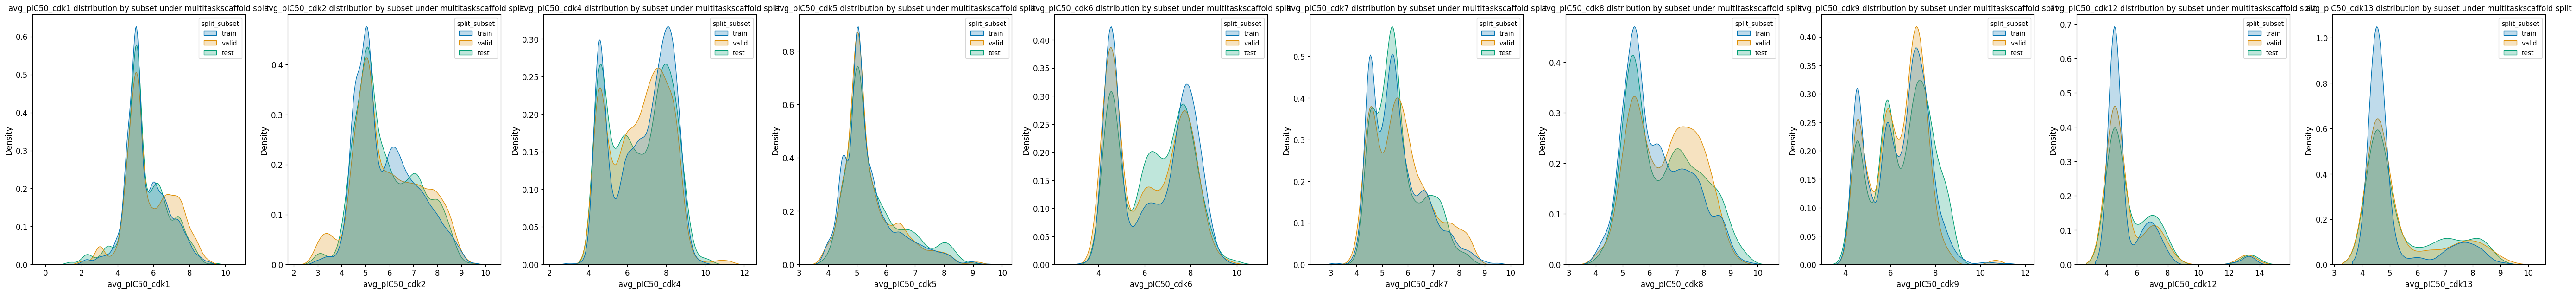

In [102]:
mtss_split_uuid = pl.split_dataset()

params = {
    "dataset_key" : dset_file,
    "splitter": splitter,
    "split_valid_frac": "0.20",
    "split_test_frac": "0.20",
    "split_strategy": "train_valid_test",
    "split_uuid": mtss_split_uuid,
    "response_cols" : response_cols,
    "id_col": "compound_id",
    "smiles_col" : "base_rdkit_smiles",
}
srdp.plot_split_subset_response_distrs(params)

In [115]:
split_file_path = 'Single_protein\cdk_all_train_valid_test_multitaskscaffold_6edb6cc5-7446-4133-a897-bc0fc8642418.csv'
curated_data_path = 'Single_protein/scaled_descriptors/cdk_all_with_rdkit_raw_descriptors.csv'


split_data = pd.read_csv(split_file_path)
curated_data = pd.read_csv(curated_data_path)

test_ids=split_data[split_data.subset == 'test'].cmpd_id.unique()
test_data = curated_data[curated_data.compound_id.isin(test_ids)]

In [116]:
from atomsci.ddm.pipeline import predict_from_model as pfm


final_pred_df = pfm.predict_from_model_file(model_path = best_model_pref.model_path,
                                      input_df = test_data,
                                      id_col =  "compound_id",
                                      smiles_col = smiles_col,
                                      response_col = response_col,
                                      is_featurized=True)

Standardizing SMILES strings for 1227 compounds.


C:\Desktop\Hackathon\AMPL\atomsci\ddm\pipeline\predict_from_model.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df['orig_smiles']=input_df[smiles_col]
C:\Desktop\Hackathon\AMPL\atomsci\ddm\pipeline\predict_from_model.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_df[smiles_col] = std_smiles
INFO:atomsci.ddm.utils.model_version_utils:final_models/cdk_all_model_ec76e17a-7ca9-4d40-b65e-5c04c9dae38d.tar.gz, 1.7.0
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: fin

['C:\\Users\\fergb\\AppData\\Local\\Temp\\tmpdlbkqged\\best_model\\checkpoint1.pt']
C:\Users\fergb\AppData\Local\Temp\tmpdlbkqged\best_model\checkpoint1.pt


<Axes: title={'center': 'Prediction of Test Set'}, xlabel='avg_pIC50_cdk2', ylabel='avg_pIC50_cdk2_pred'>

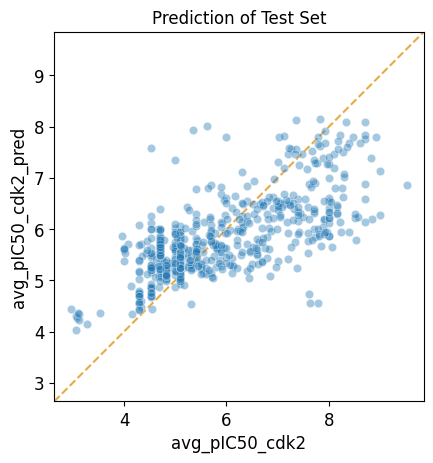

In [125]:
from atomsci.ddm.pipeline import perf_plots as pp

pp.plot_pred_vs_actual_from_df(final_pred_df,
                               actual_col='avg_pIC50_cdk2',
                               pred_col='avg_pIC50_cdk2_pred',
                               label='Prediction of Test Set')

<Axes: title={'center': 'Prediction of Test Set'}, xlabel='avg_pIC50_cdk4', ylabel='avg_pIC50_cdk4_pred'>

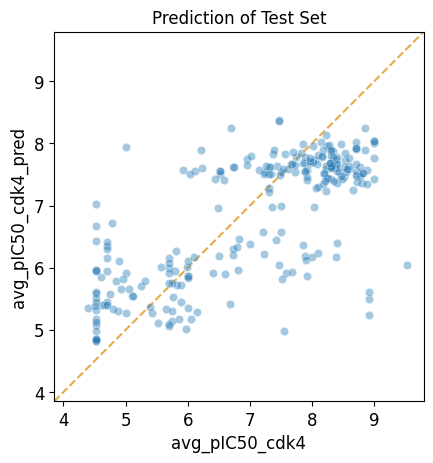

In [126]:
from atomsci.ddm.pipeline import perf_plots as pp

pp.plot_pred_vs_actual_from_df(final_pred_df,
                               actual_col='avg_pIC50_cdk4',
                               pred_col='avg_pIC50_cdk4_pred',
                               label='Prediction of Test Set')

<Axes: title={'center': 'Prediction of Test Set'}, xlabel='avg_pIC50_cdk6', ylabel='avg_pIC50_cdk6_pred'>

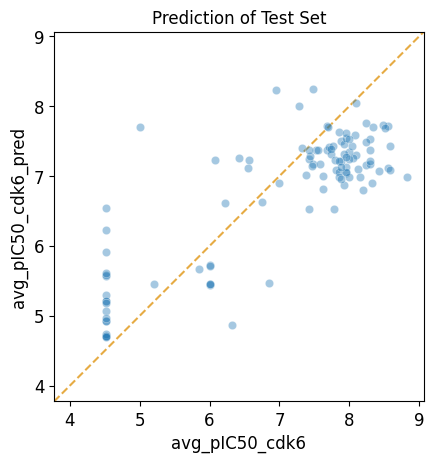

In [127]:
from atomsci.ddm.pipeline import perf_plots as pp

pp.plot_pred_vs_actual_from_df(final_pred_df,
                               actual_col='avg_pIC50_cdk6',
                               pred_col='avg_pIC50_cdk6_pred',
                               label='Prediction of Test Set')

<Axes: title={'center': 'Prediction of Test Set'}, xlabel='avg_pIC50_cdk9', ylabel='avg_pIC50_cdk9_pred'>

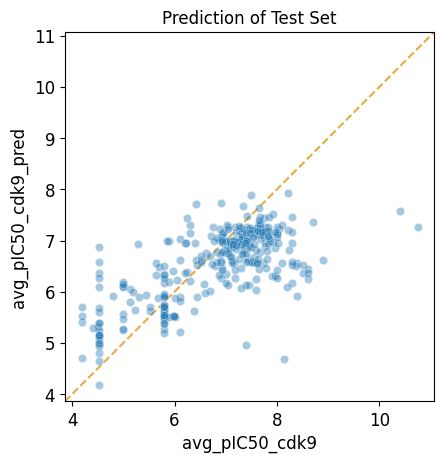

In [128]:
from atomsci.ddm.pipeline import perf_plots as pp

pp.plot_pred_vs_actual_from_df(final_pred_df,
                               actual_col='avg_pIC50_cdk9',
                               pred_col='avg_pIC50_cdk9_pred',
                               label='Prediction of Test Set')

ValueError: plot_perf_vs_epoch() can only be called for NN models